<h1 style="text-align: center; vertical-align: middle;">
    <span style="color: #B74F3D;"> 3rd Reinforcement Learning for Autonomous Accelerators Workshop Hands-On Challenge</span>
    <span style="color: #666666;">: Beam Transverse Steering at ARES Linear Accelerator</span>
</h1>

<div style="text-align: center;">
    <img src="img/rl4aa_logo.png" alt="RL4AA Logo" style="max-width: 12%; height: auto;">
</div>


<h2 style="color: #b51f2a">Getting started</h2>

- You will need **Python 3.12 or higher** to run this code &#x2757;
- You will require about **1 GB of free disk space** &#x2757;
- Make sure you have Git installed in your terminal &#x2757;

Start by cloning locally the repository of the challenge by running this command in your terminal:

```bash
git clone https://github.com/RL4AA/rl4aa25-challenge.git
```


<h2 style="color: #b51f2a">Installing virtual environment</h2>

### Using conda-forge

- If you don't have conda installed already, you can install the `miniforge` as described in the [GitHub repository](https://github.com/conda-forge/miniforge) or download from the [conda-forge site](https://conda-forge.org/download/). Once `miniforge` is installed, you can use the `conda` commands as usual.
- We recommend installing `miniforge` the day beforehand to avoid network overload during the challenge &#x2757; &#x2757;

**Note**: If you already have anaconda or miniconda installed, please remove the anaconda channels from the channel list and use `conda-forge` (community version), as the package installation from commercial channels is blocked insde of the DESY network.

Once `miniforge` is installed run this command in your terminal:

```bash
conda env create -f environment.yaml
```

This should create a virtual environment named `rl4aa25-challenge` and install the necessary packages inside.

Afterwards, activate the environment using

```bash
conda activate rl4aa25-challenge
```


<h2 style="color: #b51f2a">Check your installation</h2>
If you set up your virtual environment correctly and is activated you should be able to run the next cell without any errors:


In [1]:
import asyncio
import logging

from IPython.display import IFrame, display

from src.environments import ea
from src.visualization import restart_manual_tuning, visualization_main
from src.wrappers import PlotEpisode

INFO:src.render_3d.beam_server.beam_visualization_wrapper:Loaded .env from /Users/jankaiser/Documents/DESY/rl4aa25-challenge/src/render_3d/.env
INFO:src.render_3d.beam_server.beam_visualization_wrapper:NODE_ENV: development
INFO:src.render_3d.beam_server.beam_visualization_wrapper:VITE_FRONTEND_PORT: 5173


<h2 style="color: #b51f2a"> ARES (Accelerator Research Experiment at SINBAD)</h2>

<p>ARES is an S-band radio frequency linac at the DESY Hamburg site equipped with a photoinjector and two independently driven traveling wave accelerating structures. The main research focus is the generation and characterization of sub-femtosecond electron bunches at relativistic particle energy. The generation of short electron bunches is of high interest for radiation generation, i.e. by free electron lasers.</p>

<img src="img/ARES_layout.png" style="width:100%; margin:auto;"/>

- **Final energy**: 100-155 MeV
- **Bunch charge**: 0.01-200 pC
- **Bunch length**: 30 fs - 1 ps
- **Pulse repetition rate**: 1-50 Hz!


<h2 style="color: #b51f2a">The accelerator problem we want to solve</h2>

<p>We would like to focus and center the electron beam on a diagnostic screen using corrector and quadrupole magnets</p>

<img src="img/ares_magnets.png" style="width:60%; margin:auto;"/>


<h2 style="color: #b51f2a">Formulating the RL problem</h2>

<h3>Overview of our study case</h3>

<img src="img/ares_rl_problem.png" style="width:70%; margin:auto;"/>


<h3>Actions</h3>

<div class="row">
    <div class="column" style="width:60%;float:left">
        <p>In the ARES transverse tuning task we have 3 quadrupoles and 2 corrector magnets</p>
        <p>The actions are:
            <ul>
            <li><b>Quadrupole magnet strength</b> $k_{1,2,3}$ $[1/m^2]$</li>
            <li><b>Corrector deflection angle</b> $\theta_\mathrm{v, h}$ $[mrad]$ (vertical and horizontal</li>
            </ul>
        </p>
        <p>In our control system we can set these derived values directly according the beam energy</p>
        <p>$\implies$ <code>actions</code> $=[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$</p>
            <p>is a 5-dimensional array</p>
    </div>
    <div class="column" style="width:40%;float:right">
        <img src="img/dipole.png" style="width:50%; margin:auto;"/>
        <img src="img/quads.png" style="width:35%; margin:auto;"/>
    </div>
</div>


<h3>Observation / state</h3>

<div class="row">
    <div class="column" style="width:50%;float:left">
        <p>Observation is the information an agent receives about the current state of the environment</p>
        <p>It should provide enough information so that the agent can solve this problem.</p>
        <p>The observation does not necessarily cover the entire (internal) state of the environment.</p>
    </div>
    <div class="column" style="width:50%;float:right">
      <img src="img/screen_2.png" style="width:30%; margin:auto;"/>
      <p style="clear:both; font-size: small; text-align: center; margin-top:1em;">
          Scintillator screen to image the electrons</p>
      <img src="img/screen_1.png" style="width:30%; margin:auto;"/>
      <p style="clear:both; font-size: small; text-align: center; margin-top:1em;">The camera films the screen</p>
    </div>
</div>


<h3> The environment's state (continued)</h3>

The `state` of the EA environment can be fully described by four components:

- The **target beam**: the beam we want to achieve, our goal
  - as a 4-dimensional array $b^\mathrm{(t)}=[\mu_x^{(\mathrm{t})},\sigma_x^{(\mathrm{t})},\mu_y^{(\mathrm{t})},\sigma_y^{(\mathrm{t})}]$, where $\mu$ denotes the position on the screen, $\sigma$ denotes the beam size, and $t$ stands for "target".
- The **incoming beam**: the beam that enters the EA upstream
  - $I = [\mu_x^{(\mathrm{i})},\sigma_x^{(\mathrm{i})},\mu_y^{(\mathrm{i})},\sigma_y^{(\mathrm{i})},\mu_{xp}^{(\mathrm{i})},\sigma_{xp}^{(\mathrm{i})},\mu_{yp}^{(\mathrm{i})},\sigma_{yp}^{(\mathrm{i})},\mu_s^{(\mathrm{i})},\sigma_s^{(\mathrm{i})}]$, where $i$ stands for "incoming"
- The **magnet strengths** and **deflection angles**
  - $[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$
- The **transverse misalignments** of **quadrupoles** and the **diagnostic screen**
  - $[m_{\mathrm{Q1}}^{(\mathrm{x})},m_{\mathrm{Q1}}^{(\mathrm{y})},m_{\mathrm{Q2}}^{(\mathrm{x})},m_{\mathrm{Q2}}^{(\mathrm{y})},m_{\mathrm{Q3}}^{(\mathrm{x})},m_{\mathrm{Q3}}^{(\mathrm{y})},m_{\mathrm{S}}^{(\mathrm{x})},m_{\mathrm{S}}^{(\mathrm{y})}]$


<h3> Our definition of observation</h3>

The `observation` for this task consists of three components:

- The **target beam**: The desired beam, or the goal we aim to achieve.
  - as a 4-dimensional array $b^\mathrm{(t)}=[\mu_x^{(\mathrm{t})},\sigma_x^{(\mathrm{t})},\mu_y^{(\mathrm{t})},\sigma_y^{(\mathrm{t})}]$, where $\mu$ represents the position on the screen, $\sigma$ denotes the beam size, and $t$ refers to the "target".
- The **current beam**: The beam currently in place.
  - $b^\mathrm{(c)}=[\mu_x^{(\mathrm{c})},\sigma_x^{(\mathrm{c})},\mu_y^{(\mathrm{c})},\sigma_y^{(\mathrm{c})}]$, where $c$ represents "current".
- Magnet settings: The **magnet strengths** and **deflection angles**
  - $[k_{\mathrm{Q1}},k_{\mathrm{Q2}},\theta_\mathrm{CV},k_{\mathrm{Q3}},\theta_\mathrm{CH}]$


<h3>RL Goal and Reward</h3>

Our goal is divided into two tasks:

1. **Steering** the beam to the desired position.
2. **Focusing** the beam to the desired size.

This is included in the calculation of a scalar `reward` signal. The RL agent is tasked to maximize the cumulative reward by choosing the best actions.


<h2 style="color: #b51f2a">About libraries for RL</h2>

<p>There are several libraries that provide pre-implemented RL algorithms and frameworks for creating environments. In this notebook, we use:</p>

- [Gymnasium](https://gymnasium.farama.org/) for the environment
- [Stable-Baselines3](https://stable-baselines3.readthedocs.io/) for the RL algorithms

<img src="img/rl_libraries.png"  style="width:60%; margin:auto;"/>

<p style="clear:both; font-size: small; text-align: center; margin-top:1em;">More info <a href="https://neptune.ai/blog/the-best-tools-for-reinforcement-learning-in-python">here</a></p>

**Note**:

- Gymnasium is the successor of the [OpenAI Gym](https://www.gymlibrary.dev/).
- Stable-baselines3 now has an early-stage JAX implementation [sbx](https://github.com/araffin/sbx).


<h2 style="color: #b51f2a">A Gymnasium Environment</h2>

We take all the elements of the RL problem we previously defined and represent the tuning task as a `gym`-based environment, a standard library for RL tasks.

A custom `gym.Env` consists of the following components:

- **Initialization**: Sets up the environment and defines the `observation_space` and `action_space`
- `reset` **method**: Resets the environment for a new episode and returns a 2-tuple `(observation, info)`
- `step` **method**: Contains the core logic. It accepts an action, updates the environment state, generates a new observation, computes the reward, and returns a 5-tuple `(observation, reward, terminated, truncated, info)`.
  - `terminated` Determines whether the episode should end based on the underlying MDP (e.g., goal reached, threshold exceeded)
  - `truncated` Checks if the episode should be truncated due to conditions outside the MDP (e.g., time limits).
- `render` **method**: Provides a visual representation of the environment (e.g., video or plots).


<h2 style="color: #b51f2a">The ARES Experimental Area (ARES-EA) Environment</h2>

- We formulated the ARES-EA task as a `gym` environment, allowing our algorithm to easily interface with both the simulation and real machine backends.
- In this section, you will become familiar with the environment for beam focusing and positioning at the ARES accelerator.

Important APIs to interact with the environment:

- `reset`: Resets the magnets to their initial values. In the simulation, it also (optionally) regenerates the incoming beam and the magnet misalignments.
- `step`: Takes a given action, adjusts the magnets to new settings and observes the beam (either by running a simulation or observing the screen image in the real world).


<h2>Interacting with the ARES-EA Environment</h2>

First, let's see how the ARES-EA environment works by interacting with it.

You can run the following section to render the envrionment in 3D and see the ARES-EA reacting to your changes live.

Otherwise, you can jump directly to the next section: [Try manual tuning](#try-manual-tuning) which implements a 2D visualization of the beam screen.


### Interacting live with 3D Rendering

The visualization is built using WebGL and JavaScript to create an immersive and responsive experience.


### Starting the 3D rendering

The cell below starts the main loop, and establish a connection to show the visualization using a Websocket.


In [ ]:
# Configure logging
logging.basicConfig(
    level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s"
)
logger = logging.getLogger(__name__)

# Create a background task for the simulation
simulation_task = asyncio.create_task(visualization_main(logger=logger))

# Add a small delay to allow the web server and WebSocket to start
await asyncio.sleep(2.0)  # Adjust delay as needed

print("Simulation is running in the background. You can now run other cells.")

INFO:src.render_3d.beam_server.websocket_wrapper:WebSocket server thread started on ws://0.0.0.0:8081
INFO:src.render_3d.beam_server.beam_visualization_wrapper:JavaScript web application setup initiated on http://0.0.0.0:5173
INFO:src.render_3d.beam_server.beam_visualization_wrapper:Running in mode: production
INFO:src.render_3d.beam_server.beam_visualization_wrapper:Starting Express server (server.js) on http://0.0.0.0:5173
INFO:websockets.server:server listening on 0.0.0.0:8081
INFO:src.render_3d.beam_server.websocket_wrapper:WebSocket server running on ws://0.0.0.0:8081
INFO:src.render_3d.beam_server.segment_3d_builder:Added Quadrupole: AREAMQZM1 at position 0.17504000663757324
INFO:src.render_3d.beam_server.segment_3d_builder:Added Quadrupole: AREAMQZM2 at position 0.7250400111079216
INFO:src.render_3d.beam_server.segment_3d_builder:Added VerticalCorrector: AREAMCVM1 at position 1.0510400086641312
INFO:src.render_3d.beam_server.segment_3d_builder:Added Quadrupole: AREAMQZM3 at posi

Waiting for WebSocket client to connect...


ERROR:src.render_3d.beam_server.beam_visualization_wrapper:Vite stderr: node:internal/modules/esm/resolve:857
ERROR:src.render_3d.beam_server.beam_visualization_wrapper:Vite stderr: throw new ERR_MODULE_NOT_FOUND(packageName, fileURLToPath(base), null);
ERROR:src.render_3d.beam_server.beam_visualization_wrapper:Vite stderr: ^
ERROR:src.render_3d.beam_server.beam_visualization_wrapper:Vite stderr: 
ERROR:src.render_3d.beam_server.beam_visualization_wrapper:Vite stderr: Error [ERR_MODULE_NOT_FOUND]: Cannot find package 'express' imported from /Users/jankaiser/Documents/DESY/rl4aa25-challenge/src/render_3d/server.js
ERROR:src.render_3d.beam_server.beam_visualization_wrapper:Vite stderr:     at packageResolve (node:internal/modules/esm/resolve:857:9)
ERROR:src.render_3d.beam_server.beam_visualization_wrapper:Vite stderr:     at moduleResolve (node:internal/modules/esm/resolve:926:18)
ERROR:src.render_3d.beam_server.beam_visualization_wrapper:Vite stderr:     at defaultResolve (node:interna

Simulation is running in the background. You can now run other cells.



--- Starting simulation loop ---


INFO:__main__:Step 1: Action = [0. 0. 0. 0. 0.], Reward = 1.0, Observation = {'beam': array([ 5.2613555e-05,  3.4052122e-04, -9.4386283e-05,  2.1554634e-04],
      dtype=float32), 'magnets': array([0., 0., 0., 0., 0.], dtype=float32), 'target': array([ 0.00078388,  0.00124267, -0.00019619,  0.00077792], dtype=float32)}


New action received: [0. 0. 0. 0. 0.]


INFO:__main__:Step 2: Action = [0. 0. 0. 0. 0.], Reward = 1.0, Observation = {'beam': array([ 5.2613555e-05,  3.4052122e-04, -9.4386283e-05,  2.1554634e-04],
      dtype=float32), 'magnets': array([0., 0., 0., 0., 0.], dtype=float32), 'target': array([ 0.00078388,  0.00124267, -0.00019619,  0.00077792], dtype=float32)}
INFO:__main__:Step 3: Action = [0. 0. 0. 0. 0.], Reward = 1.0, Observation = {'beam': array([ 5.2613555e-05,  3.4052122e-04, -9.4386283e-05,  2.1554634e-04],
      dtype=float32), 'magnets': array([0., 0., 0., 0., 0.], dtype=float32), 'target': array([ 0.00078388,  0.00124267, -0.00019619,  0.00077792], dtype=float32)}
INFO:__main__:Step 4: Action = [0. 0. 0. 0. 0.], Reward = 1.0, Observation = {'beam': array([ 5.2613555e-05,  3.4052122e-04, -9.4386283e-05,  2.1554634e-04],
      dtype=float32), 'magnets': array([0., 0., 0., 0., 0.], dtype=float32), 'target': array([ 0.00078388,  0.00124267, -0.00019619,  0.00077792], dtype=float32)}
INFO:__main__:Step 5: Action = [0. 0.

Now, the web application can be displayed below in an iFrame.

You can change the magnet settings to steer the beam trajectory.

The scatter plot indicates the beam distribution on the diagnostic screen in real-time.


In [7]:
# Define the iframe as a string
display(IFrame(src="http://localhost:5173/", width=1000, height=600))

You can close the visualization task when finished:


In [8]:
simulation_task.cancel()

True

---


### Try Manual Tuning

In this part, you can interact with the ARES-EA manually, as an operator sitting in the control room.

First, let's create the environment and wrap it in `PlotEpisode` for saving the progress.


In [9]:
env = ea.TransverseTuning(
    backend="cheetah",
    action_mode="direct",
    magnet_init_mode=None,
    render_mode="rgb_array",
    backend_args={"generate_screen_images": True},
)
env = PlotEpisode(env, save_dir="plots", episode_trigger=lambda _: True)

Run the cell below to start the manual tuning.

You will see the rendered diagnostic screen rendered, with

- a blue ellipse representing the **target beam**
- a red ellipse representing the **current beam**

You can change the magnet settings by explicitly setting the values or clicking increase/decrease.

The magnet limits are $\pm 72$ 1/m for quadrupoles and $\pm 6.17$ mrad for the correctors. These are the real settings in the ARES accelerator.

Click on `Done` after you are finished, it will show a history of the actions performed by you and the beam parameters.


BoundedFloatText(value=0.0, description='Q1', max=72.0, min=-72.0)

BoundedFloatText(value=0.0, description='Q2', max=72.0, min=-72.0)

BoundedFloatText(value=0.0, description='Cor_V', max=6.178199768066406, min=-6.178199768066406)

BoundedFloatText(value=0.0, description='Q3', max=72.0, min=-72.0)

BoundedFloatText(value=0.0, description='Cor_H', max=6.178199768066406, min=-6.178199768066406)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x03d\x00\x00\x01\xfe\x08\x02\x00\x00\x00|\xe8Z\x93\x…

Button(description='Done!', style=ButtonStyle())

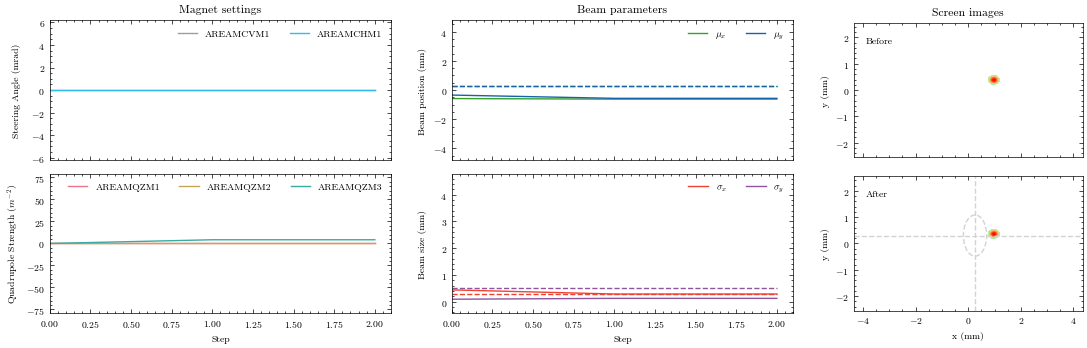

In [10]:
restart_manual_tuning(env)

---


<h2>What to do next?</h2>

After getting to know the ARES-EA environment, you can move on to design methods to control it!

In this challenge, we provide three options with baseline solutions to get you started.
These are:

- try training an RL agent. We have provided a baseline training routine with PPO. C.f. `challenge_A_rl_training.ipynb`
- try solving the ARES-EA task using an optimizer. We provided a basic solution using the scipy Nelder-Mead, c.f. `challenge_B_custom_optimizer.ipynb`
- try developing your own controller or other heuristic, c.f. `challenge_C_custom_controller.ipynb`

In all these options, your developed method will be evaluated on different ARES-EA trials. The final result will be recorded in a file, and you can upload it to Kaggle for competing with other teams, more details can be found in the individual notebooks.


<h3 style="color: #b51f2a">Code Directory Structure in RL4AA-2025 Repository</h2>

<p> This repository contains all the necessary code and configurations for running experiments using reinforcement learning (RL) and other numerical optimizers for the ARES-EA transverse tuning task. Below is an overview of the directories to help you navigate the code contents:</p>

- `src` Contains the source code for the RL environment and the GP-MPC controller
  - `src/environments/ea` contains the gymnasium environment for the ARES-EA transverse tuning task
  - `src/wrappers` contains custom wrappers for the EA environment
  - `src/train` contains scripts to train a default PPO agent to solve the task (can be used as a benchmark for evaluating MPC controller)
